In [1]:
import sys
sys.path.append("../src/python")

import os
import pathlib
import calendar
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import weathergen as wx

from tqdm import tqdm

## Diagnostics

In [2]:
def parse_dict_from_filename(filename: str, prefix: str, suffix: str,  separator='_'):
    name = os.path.basename(filename).split(suffix)[0]
    values = name.split(prefix)[-1].split(separator)[1:]
    return dict([tuple(kv.split("=")) for kv in values])

In [3]:
model_name = "wgen_glm_v3"
output_path = pathlib.Path("/work/groenke/wgen-glm-eobs/analysis")

In [4]:
# simulations_prefix = f"{model_name}_simulations"
# sims = []
# for f in tqdm(list(output_path.glob(f"{simulations_prefix}*.nc"))):
#     filepath = os.path.join(str(output_path), f)
#     attrs = parse_dict_from_filename(filepath, simulations_prefix, ".nc")
#     dataset = xr.load_dataset(filepath)
#     dataset = dataset.assign_attrs(**attrs)
#     sims.append(dataset)

In [5]:
diagnostics_prefix = f"{model_name}_diagnostics"
output_path = pathlib.Path("/work/groenke/wgen-glm-eobs/analysis")
diagnostics = []
for f in tqdm(sorted(list(output_path.glob(f"{diagnostics_prefix}*.nc")))):
    filepath = os.path.join(str(output_path), f)
    dataset = xr.load_dataset(filepath)
    diagnostics.append(dataset)

100%|██████████| 236/236 [00:16<00:00, 14.30it/s]


### Pearson residuals

$$
r(y,\tilde{y}) = \frac{y - \mathbb{E}[\tilde{y}]}{\sqrt{\mathbb{V}[\tilde{y}]}}
$$

The Pearson residuals provide a rough measure of how well the simulated distribution captures the data. In the ideal case where the model perfectly captures the data generating process, the residuals should have zero mean and constant variance; note however that they inherit the distributional structure of the predicted variable, i.e. if the underlying distribution is skewed, the residuals will also be skewed.

In [6]:
pres_prec_all = xr.concat([d.prec_pres for d in diagnostics], dim="basin").dropna(dim="basin")
pres_Tavg_all = xr.concat([d.Tavg_pres for d in diagnostics], dim="basin").dropna(dim="basin")
pres_prec_all

<xarray.DataArray 'prec_pres' (basin: 208, time: 26298)> Size: 22MB
array([[-0.75706893,  1.4445286 , -0.4831111 , ...,  1.2923853 ,
        -0.4348069 , -0.57534313],
       [-0.6972984 ,  2.4520626 , -0.05999967, ...,  0.7403049 ,
        -0.11806376, -0.5767709 ],
       [-0.8290071 ,  1.6156259 ,  0.8096444 , ...,  0.6365078 ,
         0.22762977, -0.5498873 ],
       ...,
       [-1.0049347 ,  1.7021776 ,  1.1219672 , ...,  3.1550317 ,
         0.22836904, -0.58124393],
       [-0.9393474 ,  1.5832897 ,  1.1063553 , ...,  3.1585584 ,
         0.458576  , -0.58813965],
       [ 0.16245538,  0.9639178 , -0.5348102 , ..., -0.5258961 ,
         0.3518761 ,  1.5130042 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 210kB 1950-01-01 1950-01-02 ... 2021-12-31
Dimensions without coordinates: basin

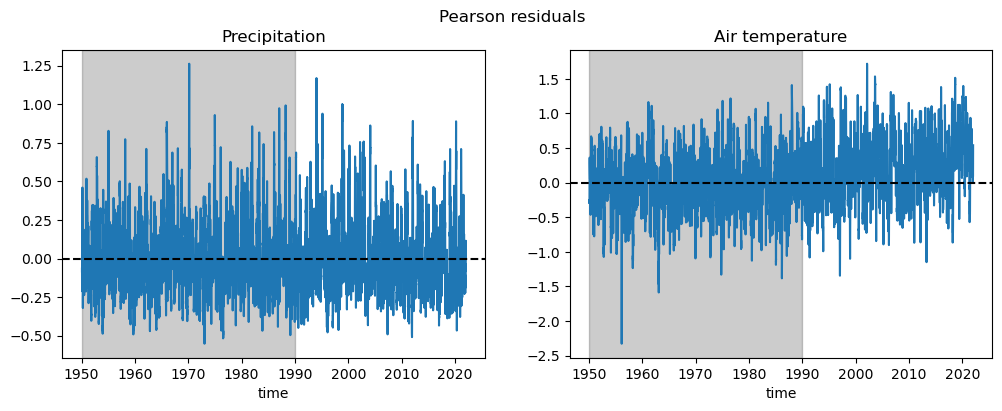

In [7]:
window_size = 30
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True)
prec_pres = pres_prec_all.mean(dim="basin").rolling(time=window_size).mean().plot(ax=axs[0])
Tavg_pres = pres_Tavg_all.mean(dim="basin").rolling(time=window_size).mean().plot(ax=axs[1])
axs[0].axvspan("1950", "1990", alpha=0.2, color="black", zorder=-10);
axs[0].axhline([0.0], c="black", linestyle="--")
axs[0].set_ylabel("")
axs[0].set_title(f"Precipitation")
axs[1].axvspan("1950", "1990", alpha=0.2, color="black", zorder=-10);
axs[1].axhline([0.0], c="black", linestyle="--")
axs[1].set_ylabel("")
axs[1].set_title(f"Air temperature")
plt.suptitle("Pearson residuals")
plt.savefig(f"../plots/pres_Tair_precip_{model_name}.pdf")
plt.show()

### Monthly diagnostics

We can investigate seasonal deficiencies by looking at monthly averages of each variable over all basins.

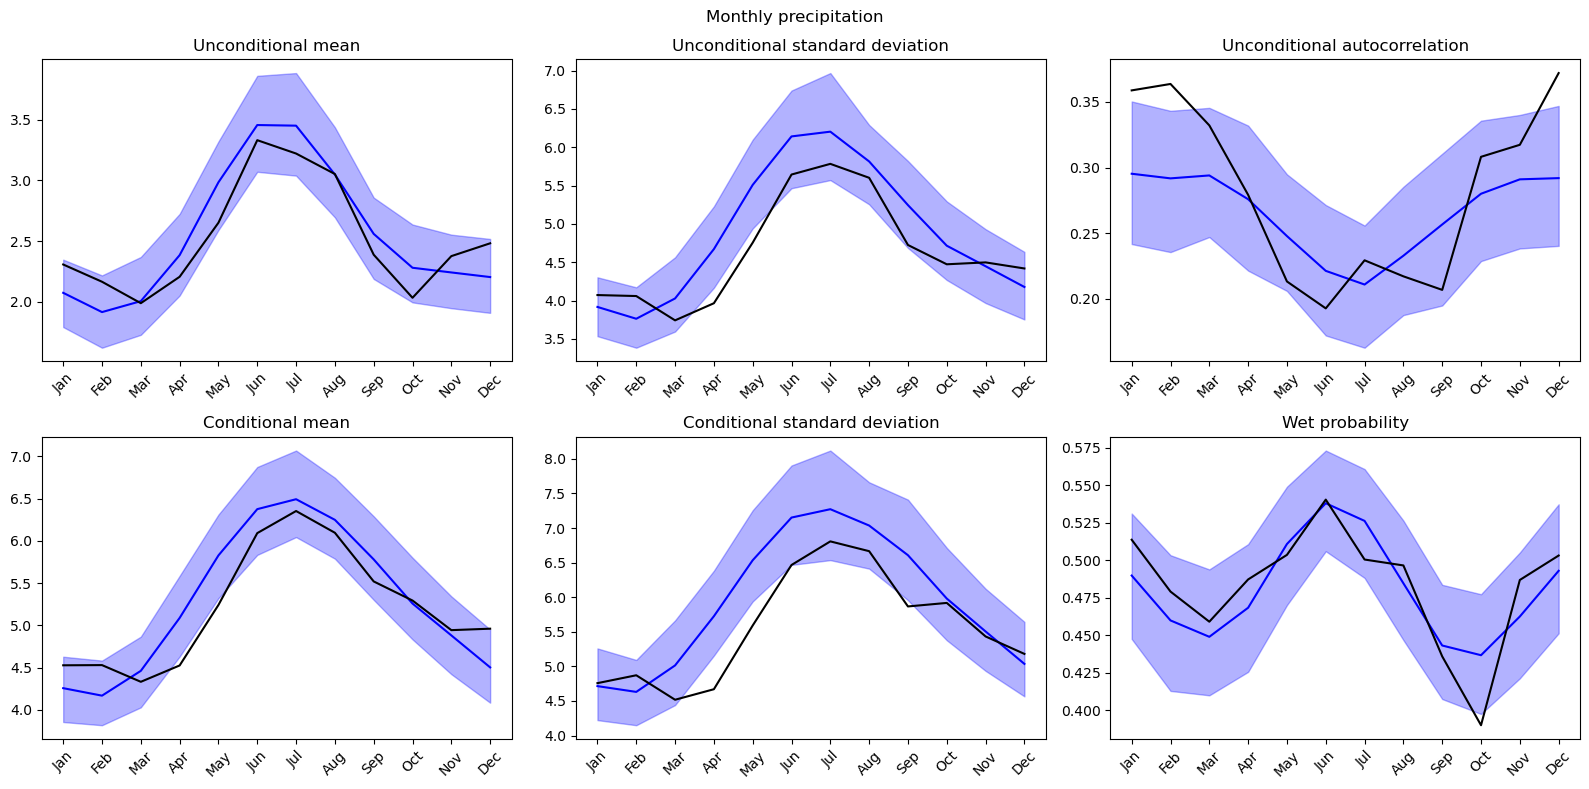

In [8]:
prec_monthly_all = xr.concat([d.prec for d in diagnostics], dim="basin").dropna(dim="basin")
prec_sim_monthly_all = xr.concat([d.prec_sim for d in diagnostics], dim="basin").dropna(dim="basin")
prec_amt_monthly_all = xr.concat([d.prec_amt for d in diagnostics], dim="basin").dropna(dim="basin")
prec_amt_sim_monthly_all = xr.concat([d.prec_amt_sim for d in diagnostics], dim="basin").dropna(dim="basin")
prec_occ_monthly_all = xr.concat([d.prec_occ for d in diagnostics], dim="basin").dropna(dim="basin")
prec_occ_sim_monthly_all = xr.concat([d.prec_occ_sim for d in diagnostics], dim="basin").dropna(dim="basin")
# plot
def configure_month_ticks(ax):
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1,13)])
    ax.tick_params(axis='x', rotation=45)
fig, axs = plt.subplots(2,3,figsize=(16,8))
axs[0,0].fill_between(
    prec_monthly_all.month,
    prec_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
# axs[0].fill_between(
#     prec_monthly_all.month,
#     prec_monthly_all.sel(var="mean").quantile(0.05, dim="basin"),
#     prec_monthly_all.sel(var="mean").quantile(0.95, dim="basin"),
#     color="black",
#     alpha=0.3,
# )
axs[0,0].plot(prec_sim_monthly_all.month, prec_sim_monthly_all.sel(var="mean").mean(dim=["basin","sample"]), color="blue")
axs[0,0].plot(prec_monthly_all.month, prec_monthly_all.sel(var="mean").mean(dim="basin"), color="black")
axs[0,0].set_title("Unconditional mean")
configure_month_ticks(axs[0,0])
axs[0,1].fill_between(
    prec_monthly_all.month,
    prec_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[0,1].plot(prec_sim_monthly_all.month, prec_sim_monthly_all.sel(var="std").mean(dim=["basin","sample"]), color="blue")
axs[0,1].plot(prec_monthly_all.month, prec_monthly_all.sel(var="std").mean(dim="basin"), color="black")
axs[0,1].set_title("Unconditional standard deviation")
configure_month_ticks(axs[0,1])
axs[0,2].fill_between(
    prec_monthly_all.month,
    prec_sim_monthly_all.sel(var="autocorr").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_sim_monthly_all.sel(var="autocorr").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)

axs[0,2].plot(prec_sim_monthly_all.month, prec_sim_monthly_all.sel(var="autocorr").mean(dim=["basin","sample"]), color="blue")
axs[0,2].plot(prec_monthly_all.month, prec_monthly_all.sel(var="autocorr").mean(dim="basin"), color="black")
axs[0,2].set_title("Unconditional autocorrelation")
configure_month_ticks(axs[0,2])

axs[1,0].fill_between(
    prec_amt_monthly_all.month,
    prec_amt_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_amt_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
# axs[0].fill_between(
#     prec_monthly_all.month,
#     prec_monthly_all.sel(var="mean").quantile(0.05, dim="basin"),
#     prec_monthly_all.sel(var="mean").quantile(0.95, dim="basin"),
#     color="black",
#     alpha=0.3,
# )
axs[1,0].plot(prec_amt_monthly_all.month, prec_amt_sim_monthly_all.sel(var="mean").mean(dim=["basin","sample"]), color="blue")
axs[1,0].plot(prec_amt_monthly_all.month, prec_amt_monthly_all.sel(var="mean").mean(dim="basin"), color="black")
axs[1,0].set_title("Conditional mean")
configure_month_ticks(axs[1,0])
axs[1,1].fill_between(
    prec_amt_monthly_all.month,
    prec_amt_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_amt_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[1,1].plot(prec_amt_monthly_all.month, prec_amt_sim_monthly_all.sel(var="std").mean(dim=["basin","sample"]), color="blue")
axs[1,1].plot(prec_amt_monthly_all.month, prec_amt_monthly_all.sel(var="std").mean(dim="basin"), color="black")
axs[1,1].set_title("Conditional standard deviation")
configure_month_ticks(axs[1,1])
axs[1,2].fill_between(
    prec_occ_monthly_all.month,
    prec_occ_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.05, dim=["sample"]),
    prec_occ_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[1,2].plot(prec_occ_sim_monthly_all.month, prec_occ_sim_monthly_all.sel(var="mean").mean(dim=["basin","sample"]), color="blue")
axs[1,2].plot(prec_occ_monthly_all.month, prec_occ_monthly_all.sel(var="mean").mean(dim="basin"), color="black")
axs[1,2].set_title("Wet probability")
configure_month_ticks(axs[1,2])
plt.suptitle("Monthly precipitation")
plt.savefig(f"../plots/prec_monthly_{model_name}.pdf")
plt.tight_layout()

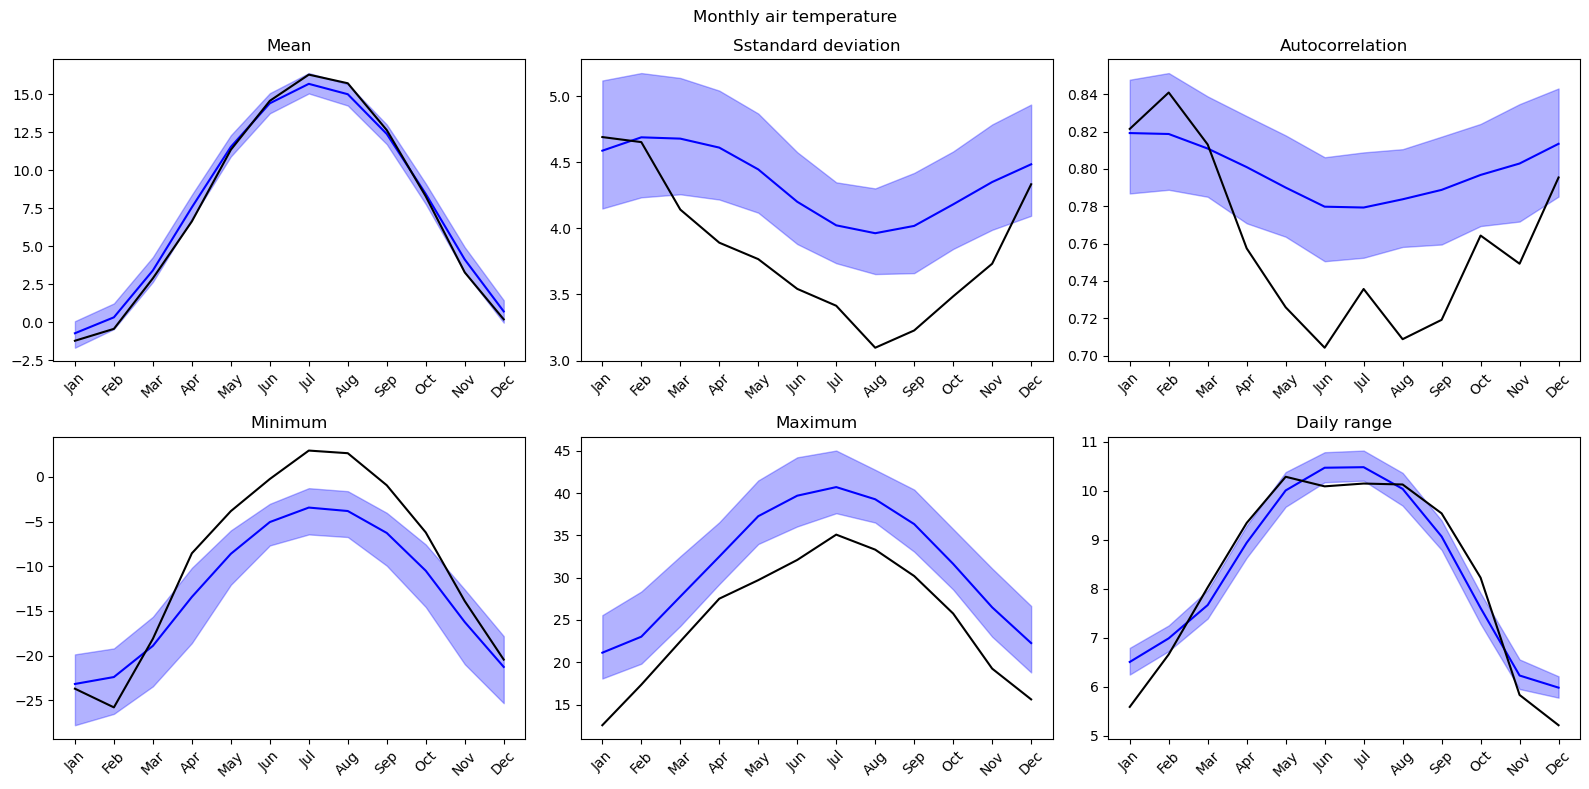

In [9]:
Tavg_monthly_all = xr.concat([d.Tair_mean for d in diagnostics], dim="basin").dropna(dim="basin")
Tavg_sim_monthly_all = xr.concat([d.Tavg_sim for d in diagnostics], dim="basin").dropna(dim="basin")
Tmin_monthly_all = xr.concat([d.Tair_min for d in diagnostics], dim="basin").dropna(dim="basin")
Tmin_sim_monthly_all = xr.concat([d.Tmin_sim for d in diagnostics], dim="basin").dropna(dim="basin")
Tmax_monthly_all = xr.concat([d.Tair_max for d in diagnostics], dim="basin").dropna(dim="basin")
Tmax_sim_monthly_all = xr.concat([d.Tmax_sim for d in diagnostics], dim="basin").dropna(dim="basin")
# plot
fig, axs = plt.subplots(2,3,figsize=(16,8))
axs[0,0].fill_between(
    Tavg_monthly_all.month,
    Tavg_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Tavg_sim_monthly_all.sel(var="mean").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
# axs[0].fill_between(
#     Tavg_monthly_all.month,
#     Tavg_monthly_all.sel(var="mean").quantile(0.05, dim="basin"),
#     Tavg_monthly_all.sel(var="mean").quantile(0.95, dim="basin"),
#     color="black",
#     alpha=0.3,
# )
axs[0,0].plot(Tavg_sim_monthly_all.month, Tavg_sim_monthly_all.sel(var="mean").mean(dim=["basin","sample"]), color="blue")
axs[0,0].plot(Tavg_monthly_all.month, Tavg_monthly_all.sel(var="mean").mean(dim="basin"), color="black")
axs[0,0].set_title("Mean")
configure_month_ticks(axs[0,0])
axs[0,1].fill_between(
    Tavg_monthly_all.month,
    Tavg_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Tavg_sim_monthly_all.sel(var="std").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[0,1].plot(Tavg_sim_monthly_all.month, Tavg_sim_monthly_all.sel(var="std").mean(dim=["basin","sample"]), color="blue")
axs[0,1].plot(Tavg_monthly_all.month, Tavg_monthly_all.sel(var="std").mean(dim="basin"), color="black")
axs[0,1].set_title("Sstandard deviation")
configure_month_ticks(axs[0,1])
axs[0,2].fill_between(
    Tavg_monthly_all.month,
    Tavg_sim_monthly_all.sel(var="autocorr").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Tavg_sim_monthly_all.sel(var="autocorr").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)

axs[0,2].plot(Tavg_sim_monthly_all.month, Tavg_sim_monthly_all.sel(var="autocorr").mean(dim=["basin","sample"]), color="blue")
axs[0,2].plot(Tavg_monthly_all.month, Tavg_monthly_all.sel(var="autocorr").mean(dim="basin"), color="black")
axs[0,2].set_title("Autocorrelation")
configure_month_ticks(axs[0,2])

axs[1,0].fill_between(
    Tmin_monthly_all.month,
    Tmin_sim_monthly_all.sel(var="min").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Tmin_sim_monthly_all.sel(var="min").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
# axs[0].fill_between(
#     Tavg_monthly_all.month,
#     Tavg_monthly_all.sel(var="mean").quantile(0.05, dim="basin"),
#     Tavg_monthly_all.sel(var="mean").quantile(0.95, dim="basin"),
#     color="black",
#     alpha=0.3,
# )
axs[1,0].plot(Tmin_monthly_all.month, Tmin_sim_monthly_all.sel(var="min").mean(dim=["basin","sample"]), color="blue")
axs[1,0].plot(Tmin_monthly_all.month, Tmin_monthly_all.sel(var="min").mean(dim="basin"), color="black")
axs[1,0].set_title("Minimum")
configure_month_ticks(axs[1,0])
axs[1,1].fill_between(
    Tmax_monthly_all.month,
    Tmax_sim_monthly_all.sel(var="max").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Tmax_sim_monthly_all.sel(var="max").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[1,1].plot(Tmax_monthly_all.month, Tmax_sim_monthly_all.sel(var="max").mean(dim=["basin","sample"]), color="blue")
axs[1,1].plot(Tmax_monthly_all.month, Tmax_monthly_all.sel(var="max").mean(dim="basin"), color="black")
axs[1,1].set_title("Maximum")
configure_month_ticks(axs[1,1])
Trange_sim = Tmax_sim_monthly_all - Tmin_sim_monthly_all
Trange_obs = Tmax_monthly_all - Tmin_monthly_all
axs[1,2].fill_between(
    Tmax_monthly_all.month,
    Trange_sim.sel(var="mean").mean(dim="basin").quantile(0.05, dim=["sample"]),
    Trange_sim.sel(var="mean").mean(dim="basin").quantile(0.95, dim=["sample"]),
    color="blue",
    alpha=0.3,
)
axs[1,2].plot(Tmax_monthly_all.month, Trange_sim.sel(var="mean").mean(dim=["basin","sample"]), color="blue")
axs[1,2].plot(Tmax_monthly_all.month, Trange_obs.sel(var="mean").mean(dim="basin"), color="black")
axs[1,2].set_title("Daily range")
configure_month_ticks(axs[1,2])
plt.suptitle("Monthly air temperature")
plt.savefig(f"../plots/Tair_monthly_{model_name}.pdf")
plt.tight_layout()

### Ensemble QQ-plots

Another visual check is to construct ensemble QQ-plots over all basins.

In [10]:
prec_qs_all = xr.concat([d.prec_quantiles for d in diagnostics], dim="basin").rename({'quantile': 'qs'})
prec_sim_qs_all = xr.concat([d.prec_sim_quantiles for d in diagnostics], dim="basin").rename({'quantile': 'qs'})
Tavg_qs_all = xr.concat([d.Tair_mean_quantiles for d in diagnostics], dim="basin").rename({'quantile': 'qs'})
Tavg_sim_qs_all = xr.concat([d.Tavg_sim_quantiles for d in diagnostics], dim="basin").rename({'quantile': 'qs'})

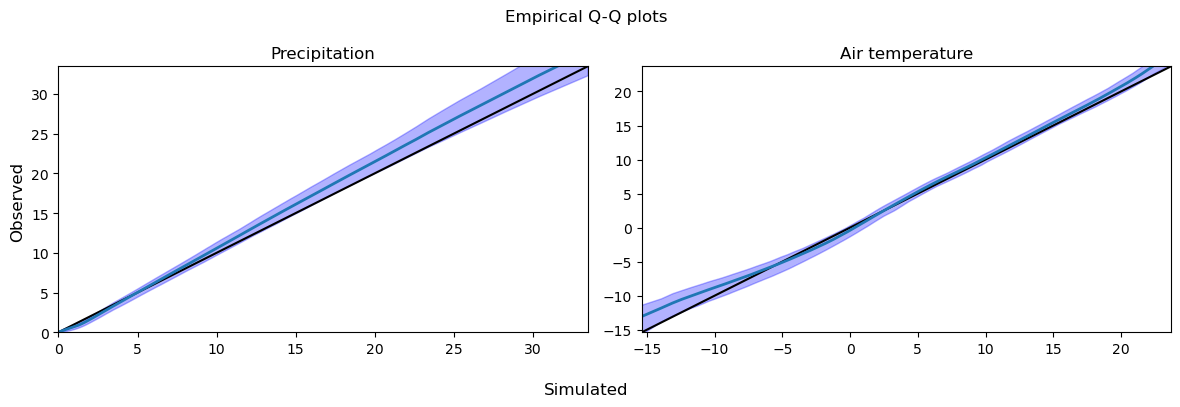

In [11]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
# preicp
axs[0].fill_between(
    prec_qs_all.mean(dim="basin"),
    prec_sim_qs_all.mean(dim=["basin"]).quantile(0.01, dim="sample"),
    prec_sim_qs_all.mean(dim=["basin"]).quantile(0.99, dim="sample"),
    color="blue",
    alpha=0.3,
)
axs[0].axline((0,0), slope=1, color="black")
axs[0].plot(prec_qs_all.mean(dim="basin"), prec_sim_qs_all.mean(dim=["basin","sample"]), linewidth=2.0)
ymax0 = prec_qs_all.mean(dim="basin").max()
axs[0].set_xlim(0,ymax0)
axs[0].set_ylim(0,ymax0)
axs[0].set_title("Precipitation")
# mean air temperature
axs[1].fill_between(
    Tavg_qs_all.mean(dim="basin"),
    Tavg_sim_qs_all.mean(dim=["basin"]).quantile(0.01, dim="sample"),
    Tavg_sim_qs_all.mean(dim=["basin"]).quantile(0.99, dim="sample"),
    color="blue",
    alpha=0.3,
)
axs[1].axline((0,0), slope=1, color="black")
axs[1].plot(Tavg_qs_all.mean(dim="basin"), Tavg_sim_qs_all.mean(dim=["basin","sample"]), linewidth=2.0)
ymin0 = Tavg_qs_all.mean(dim="basin").min()
ymax0 = Tavg_qs_all.mean(dim="basin").max()
axs[1].set_xlim(ymin0,ymax0)
axs[1].set_ylim(ymin0,ymax0)
axs[1].set_title("Air temperature")
fig.supxlabel("Simulated")
fig.supylabel("Observed")
plt.suptitle("Empirical Q-Q plots")
plt.savefig(f"../plots/qq_Tair_prec_{model_name}.pdf")
plt.tight_layout();